Instagram data loaded.
TikTok data loaded.
YouTube data loaded.
--- Starting Outlier & High-Performer Detection ---

--- Instagram Outlier Analysis (Engagement Rate) ---
Total valid influencers: 0
Q1: nan, Q3: nan, IQR: nan
Upper Bound for Outliers: nan%
Total outliers detected: 0
High-performers (above upper bound): 0

No high-performing outliers detected.

Skipping TikTok: Missing essential columns for analysis: ['name']. Please check your column mappings.

--- YouTube Outlier Analysis (Engagement Rate) ---
Total valid influencers: 0
Q1: nan, Q3: nan, IQR: nan
Upper Bound for Outliers: nan%
Total outliers detected: 0
High-performers (above upper bound): 0

No high-performing outliers detected.


ValueError: List of boxplot statistics and `positions` values must have same the length

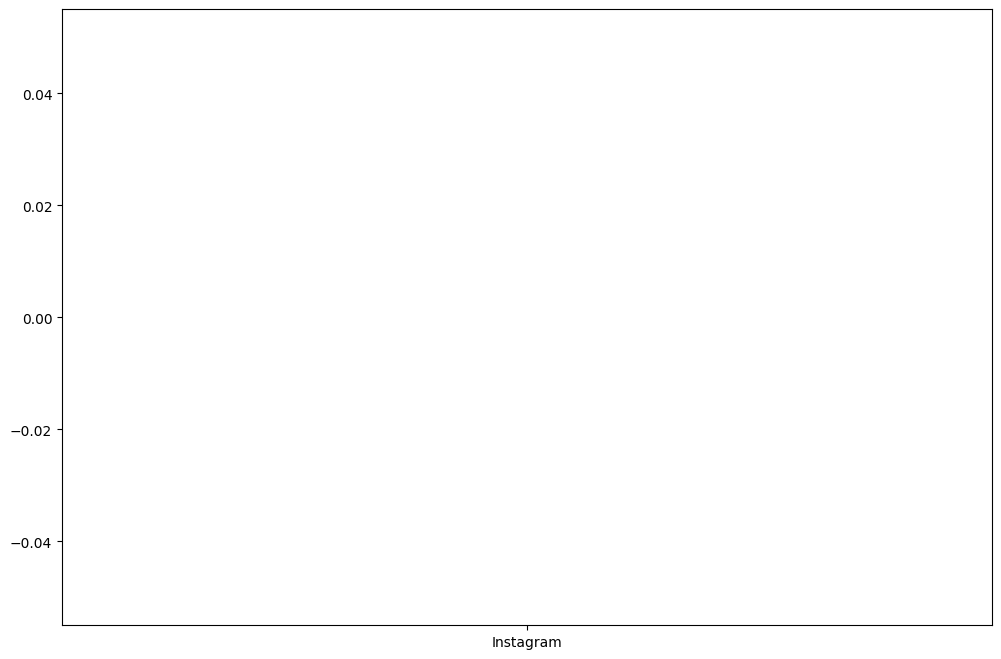

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Helper Function for Cleaning Numeric Columns (Handles 'K', 'M' suffixes) ---
def clean_numeric_column(series):
    """
    Cleans a pandas Series by converting values with 'K' or 'M' suffixes to numeric.
    Handles NaNs and non-numeric values by coercing them to NaN.
    """
    if not pd.api.types.is_numeric_dtype(series):
        s = series.astype(str).str.strip().str.upper()
        def convert_value(value):
            if pd.isna(value) or value in ['NAN', 'NONE', '']:
                return np.nan
            value = value.replace(',', '')
            if 'M' in value:
                return float(value.replace('M', '')) * 1_000_000
            elif 'K' in value:
                return float(value.replace('K', '')) * 1_000
            else:
                return pd.to_numeric(value, errors='coerce')
        return s.apply(convert_value)
    else:
        return pd.to_numeric(series, errors='coerce')

# --- Helper Function to Calculate Engagement Rate ---
def calculate_engagement_rate(row, sub_col_name, likes_col_name, comments_col_name, shares_col_name=None):
    """
    Calculates a simplified engagement rate.
    Formula: (Average Likes + Average Comments + Average Shares) / Subscribers * 100
    Handles potential NaN values and division by zero.
    """
    subscribers = row.get(sub_col_name)
    likes = row.get(likes_col_name, 0)
    comments = row.get(comments_col_name, 0)
    shares = row.get(shares_col_name, 0) if shares_col_name else 0
    likes = 0 if pd.isna(likes) else float(likes)
    comments = 0 if pd.isna(comments) else float(comments)
    shares = 0 if pd.isna(shares) else float(shares)
    subscribers = pd.to_numeric(subscribers, errors='coerce')

    if pd.isna(subscribers) or subscribers == 0:
        return np.nan
    total_interactions = likes + comments + shares
    return (total_interactions / subscribers) * 100

# --- Main Analysis Function for Outlier & High-Performer Detection ---
def analyze_outliers_iqr(
    insta_df, tiktok_df, youtube_df,
    insta_col_map={
        'subscribers': 'subscribers',
        'likes_avg': 'authentic_engagement',
        'comments_avg': 'engagement_average',
        'name': 'name'
    },
    tiktok_col_map={
        'subscribers': 'subscribers',
        'likes_avg': 'likes_avg',
        'comments_avg': 'comments_avg',
        'shares_avg': 'shares_avg',
        'name': 'name'
    },
    yt_col_map={
        'subscribers': 'subscribers',
        'likes_avg': 'avg_likes',
        'comments_avg': 'avg_comments',
        'name': 'name'
    }
):
    """
    Detects outliers and high-performers based on Engagement Rate using the IQR method.
    """
    print("--- Starting Outlier & High-Performer Detection ---")
    all_data = []
    
    platforms_config = {
        'Instagram': {'df': insta_df, 'col_map': insta_col_map, 'has_shares': False},
        'TikTok': {'df': tiktok_df, 'col_map': tiktok_col_map, 'has_shares': True},
        'YouTube': {'df': youtube_df, 'col_map': yt_col_map, 'has_shares': False}
    }

    for platform, config in platforms_config.items():
        df = config['df']
        col_map = config['col_map']
        has_shares = config['has_shares']

        if df is None:
            print(f"\nSkipping {platform}: DataFrame is None.")
            continue

        sub_col = col_map.get('subscribers')
        likes_col = col_map.get('likes_avg')
        comments_col = col_map.get('comments_avg')
        shares_col = col_map.get('shares_avg') if has_shares else None
        name_col = col_map.get('name')
        
        essential_cols = [sub_col, likes_col, comments_col, name_col]
        if shares_col: essential_cols.append(shares_col)
        missing_cols = [col for col in essential_cols if col is None or col not in df.columns]
        
        if missing_cols:
            print(f"\nSkipping {platform}: Missing essential columns for analysis: {missing_cols}. Please check your column mappings.")
            continue

        # --- Data Cleaning ---
        df_cleaned = df.copy()
        for col in [sub_col, likes_col, comments_col, shares_col]:
            if col and col in df_cleaned.columns:
                df_cleaned[col] = clean_numeric_column(df_cleaned[col])

        # --- Calculate Engagement Rate ---
        df_cleaned['engagement_rate'] = df_cleaned.apply(
            lambda row: calculate_engagement_rate(row, sub_col, likes_col, comments_col, shares_col),
            axis=1
        )

        df_cleaned['platform'] = platform
        
        # --- Detect Outliers using IQR ---
        q1 = df_cleaned['engagement_rate'].quantile(0.25)
        q3 = df_cleaned['engagement_rate'].quantile(0.75)
        iqr = q3 - q1
        
        # Define outlier bounds
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Identify outliers
        outliers = df_cleaned[
            (df_cleaned['engagement_rate'] < lower_bound) |
            (df_cleaned['engagement_rate'] > upper_bound)
        ].copy()
        
        # --- Identify High-Performers (Upper Outliers) ---
        high_performers = outliers[outliers['engagement_rate'] > upper_bound].copy()

        print(f"\n--- {platform} Outlier Analysis (Engagement Rate) ---")
        print(f"Total valid influencers: {df_cleaned['engagement_rate'].notna().sum()}")
        print(f"Q1: {q1:.2f}, Q3: {q3:.2f}, IQR: {iqr:.2f}")
        print(f"Upper Bound for Outliers: {upper_bound:.2f}%")
        print(f"Total outliers detected: {len(outliers)}")
        print(f"High-performers (above upper bound): {len(high_performers)}")
        
        if not high_performers.empty:
            print("\nTop 5 High-Performing Influencers (by Engagement Rate):")
            print(high_performers.sort_values(by='engagement_rate', ascending=False).head(5)[[name_col, sub_col, 'engagement_rate']].to_string(index=False))
        else:
            print("\nNo high-performing outliers detected.")

        # --- Prepare data for combined plot ---
        df_cleaned['platform'] = platform
        all_data.append(df_cleaned[['platform', 'engagement_rate']])

    # --- Combined Box Plot Visualization ---
    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        plt.figure(figsize=(12, 8))
        sns.boxplot(x='platform', y='engagement_rate', data=combined_df)
        plt.title('Distribution of Engagement Rate by Platform (with Outliers)')
        plt.xlabel('Platform')
        plt.ylabel('Engagement Rate (%)')
        plt.ylim(0, combined_df['engagement_rate'].quantile(0.99) * 1.5) # Set y-limit to a reasonable value to prevent extreme outliers from skewing the plot
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    else:
        print("\nNo data to visualize.")

    print("\n--- Outlier & High-Performer Detection Complete ---")

# --- EXAMPLE DATA LOADING (REPLACE WITH YOUR ACTUAL DATA) ---
try:
    # Ensure these columns exist in your Instagram data
    insta_df = pd.read_csv('./Clean_Data/merged_instagram_data_cleaned.csv')
    print("Instagram data loaded.")
except FileNotFoundError:
    print("instagram_data.csv not found. Please check the file path.")
    insta_df = None

try:
    # Ensure these columns exist in your TikTok data
    tiktok_df = pd.read_csv('./Clean_Data/merged_tiktok_data_cleaned.csv')
    print("TikTok data loaded.")
except FileNotFoundError:
    print("tiktok_data.csv not found. Please check the file path.")
    tiktok_df = None

try:
    # Ensure these columns exist in your YouTube data
    youtube_df = pd.read_csv('./Clean_Data/merged_youtube_data_cleaned.csv')
    print("YouTube data loaded.")
except FileNotFoundError:
    print("youtube_data.csv not found. Please check the file path.")
    youtube_df = None


# --- CALL THE OUTLIER ANALYSIS FUNCTION ---
# VERY IMPORTANT:
# 1. Update the column mappings to match your CSV headers exactly.
# 2. Update the 'name' column if it's different in your datasets.
analyze_outliers_iqr(
    insta_df=insta_df,
    tiktok_df=tiktok_df,
    youtube_df=youtube_df,
    insta_col_map={
        'subscribers': 'subscribers',
        'likes_avg': 'authentic_engagement',
        'comments_avg': 'engagement_average',
        'name': 'name' # <--- Update to the name column in your Instagram data
    },
    tiktok_col_map={
        'subscribers': 'subscribers',
        'likes_avg': 'likes_avg',
        'comments_avg': 'comments_avg',
        'shares_avg': 'shares_avg', # <--- Update if you have this column
        'name': 'name' # <--- Update to the name column in your TikTok data
    },
    yt_col_map={
        'subscribers': 'subscribers',
        'likes_avg': 'avg_likes',
        'comments_avg': 'avg_comments',
        'name': 'name' # <--- Update to the name column in your YouTube data
    }
)